#### Data generation from the GAMI-Net paper

In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from gaminet import GAMINet
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

In [2]:
def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def rmse(label, pred, scaler):
    pred = scaler.inverse_transform(pred.reshape([-1, 1]))
    label = scaler.inverse_transform(label.reshape([-1, 1]))
    return np.sqrt(np.mean((pred - label)**2))

def data_generator1(datanum, dist="uniform", random_state=0):
    
    nfeatures = 100
    np.random.seed(random_state)
    x = np.random.uniform(0, 1, [datanum, nfeatures])
    x1, x2, x3, x4, x5, x6 = [x[:, [i]] for i in range(6)]

    def cliff(x1, x2):
        # x1: -20,20
        # x2: -10,5
        x1 = (2 * x1 - 1) * 20
        x2 = (2 * x2 - 1) * 7.5 - 2.5
        term1 = -0.5 * x1 ** 2 / 100
        term2 = -0.5 * (x2 + 0.03 * x1 ** 2 - 3) ** 2
        y = 10 * np.exp(term1 + term2)
        return  y

    y = (8 * (x1 - 0.5) ** 2
        + 0.1 * np.exp(-8 * x2 + 4)
        + 3 * np.sin(2 * np.pi * x3 * x4)
        + cliff(x5, x6)).reshape([-1,1]) + 1 * np.random.normal(0, 1, [datanum, 1])

    task_type = "Regression"
    meta_info = {"X" + str(i + 1):{'type':'continuous'} for i in range(nfeatures)}
    meta_info.update({'Y':{'type':'target'}})         
    for i, (key, item) in enumerate(meta_info.items()):
        if item['type'] == 'target':
            sy = MinMaxScaler((0, 1))
            y = sy.fit_transform(y)
            meta_info[key]['scaler'] = sy
        else:
            sx = MinMaxScaler((0, 1))
            sx.fit([[0], [1]])
            x[:,[i]] = sx.transform(x[:,[i]])
            meta_info[key]['scaler'] = sx

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)
    return train_x, test_x, train_y, test_y, task_type, meta_info, metric_wrapper(rmse, sy)

train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_generator1(datanum=10000, random_state=0)

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from neural_additive_models.data_utils import load_correlated_data
import numpy as np


def data_generator_correlated(datanum):
    dataset = load_correlated_data(n=datanum)
    x, y = dataset['X'].to_numpy(), dataset['y'].reshape([-1, 1])
    nfeatures = x.shape[1]

    task_type = "Regression"
    meta_info = {"X" + str(i + 1):{'type':'continuous'} for i in range(nfeatures)}
    meta_info.update({'Y':{'type':'target'}})         
    for i, (key, item) in enumerate(meta_info.items()):
        if item['type'] == 'target':
            sy = MinMaxScaler((0, 1))
            y = sy.fit_transform(y)
            meta_info[key]['scaler'] = sy
        else:
            sx = MinMaxScaler((0, 1))
            sx.fit([[0], [1]])
            x[:,[i]] = sx.transform(x[:,[i]])
            meta_info[key]['scaler'] = sx

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2)
    return train_x, test_x, train_y, test_y, task_type, meta_info, metric_wrapper(rmse, sy)


In [4]:
train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_generator_correlated(10000)


#### GAMI-Net training

In [10]:
## Note the current GAMINet API requires input features being normalized within 0 to 1.
model = GAMINet(meta_info=meta_info, interact_num=20, 
                interact_arch=[40] * 5, subnet_arch=[40] * 5, 
                batch_size=200, task_type=task_type, activation_func=tf.nn.relu, 
                main_effect_epochs=5000, interaction_epochs=5000, tuning_epochs=500, 
                lr_bp=[0.0001, 0.0001, 0.0001], early_stop_thres=[50, 50, 50],
                heredity=True, loss_threshold=0.01, reg_clarity=1,
                mono_increasing_list=[], mono_decreasing_list=[],
                verbose=True, val_ratio=0.2, random_state=0)

model.fit(train_x, train_y)

val_x = train_x[model.val_idx, :]
val_y = train_y[model.val_idx, :]
tr_x = train_x[model.tr_idx, :]
tr_y = train_y[model.tr_idx, :]
pred_train = model.predict(tr_x)
pred_val = model.predict(val_x)
pred_test = model.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(tr_y, pred_train),5), 
                      np.round(get_metric(val_y, pred_val),5),
                      np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########


c:\Users\dejvi\Desktop\neural-additive-models-xai-seminar\venv37\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'gami_net_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Main effects training epoch: 1, train loss: 0.01602, val loss: 0.01664
Main effects training epoch: 2, train loss: 0.01312, val loss: 0.01359
Main effects training epoch: 3, train loss: 0.01212, val loss: 0.01263
Main effects training epoch: 4, train loss: 0.01127, val loss: 0.01180
Main effects training epoch: 5, train loss: 0.01042, val loss: 0.01097
Main effects training epoch: 6, train loss: 0.00954, val loss: 0.01008
Main effects training epoch: 7, train loss: 0.00856, val loss: 0.00907
Main effects training epoch: 8, train loss: 0.00740, val loss: 0.00783
Main effects training epoch: 9, train loss: 0.00633, val loss: 0.00663
Main effects training epoch: 10, train loss: 0.00554, val loss: 0.00574
Main effects training epoch: 11, train loss: 0.00518, val loss: 0.00531
Main effects training epoch: 12, train loss: 0.00498, val loss: 0.00509
Main effects training epoch: 13, train loss: 0.00482, val loss: 0.00491
Main effects training epoch: 14, train loss: 0.00463, val loss: 0.00472
M

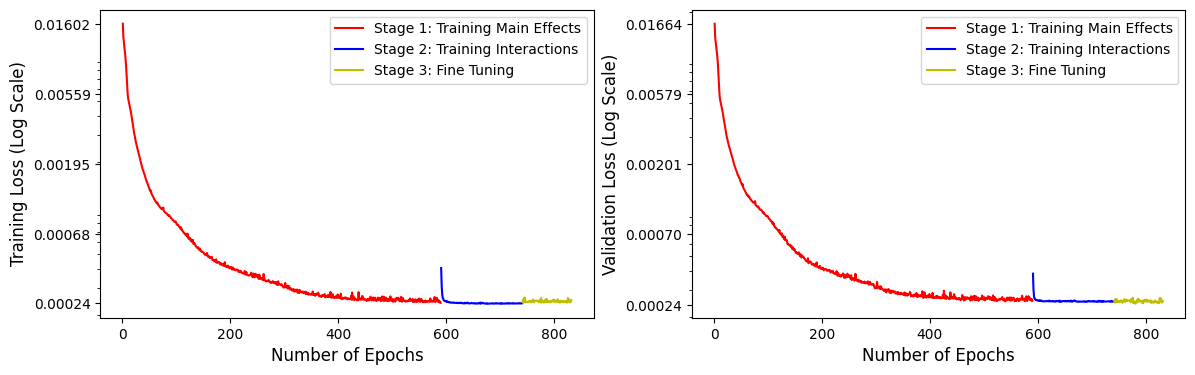

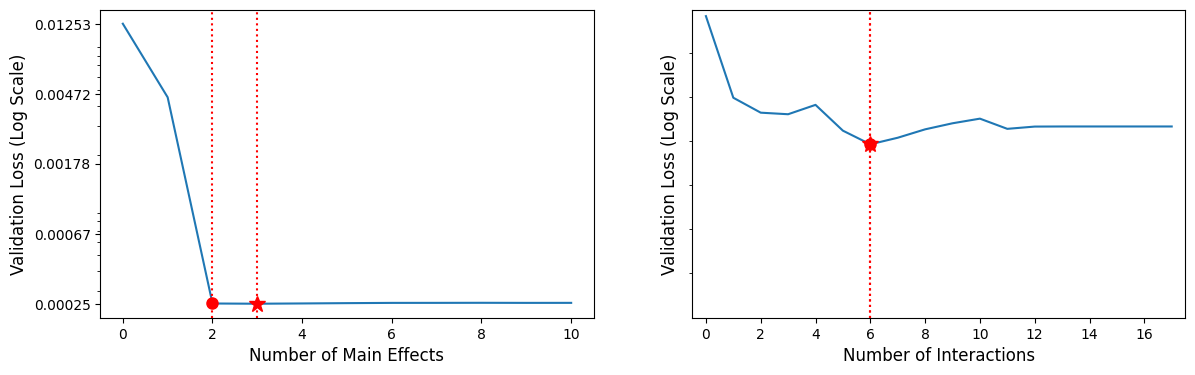

In [11]:
simu_dir = "./results/"
if not os.path.exists(simu_dir):
    os.makedirs(simu_dir)

data_dict_logs = model.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=simu_dir, name="s1_traj_plot", log_scale=True, save_png=True)
plot_regularization(data_dict_logs, folder=simu_dir, name="s1_regu_plot", log_scale=True, save_png=True)

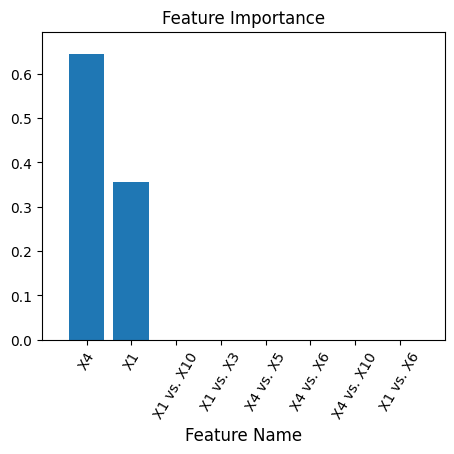

In [12]:
data_dict_global = model.global_explain(save_dict=False)
feature_importance_visualize(data_dict_global, save_png=True, folder=simu_dir, name='s1_feature')